# Quantized anomaly study (Part 2)

Encode normal and anomalous test spectrograms with Stage 1 VQ-VAE; compare code-index usage (normal vs anomaly), spatial "where indices change" map, and optional z-distance. Output summary for mask priors and code-preference in the anomaly generation module.

## 1. Setup: data and Stage 1 VQ-VAE

Load test data grouped by machine_id and label; load trained VQ-VAE per machine type.

In [1]:
import sys
from pathlib import Path
from collections import defaultdict

_cwd = Path(".").resolve()
PROJECT_ROOT = _cwd.parent if _cwd.name == "notebooks" else _cwd
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import torch
import matplotlib.pyplot as plt

from src.data.dataset import DCASE2020Task2LogMelDataset, DCASE2020Task2TestDataset
from src.models.vq_vae.autoencoders import VQ_VAE_2Layer

DATA_PATH = PROJECT_ROOT / "../data/dcase2020-task2-dev-dataset"
if not DATA_PATH.exists():
    DATA_PATH = PROJECT_ROOT / "data/dcase2020-task2-dev-dataset"
CKPT_DIR = PROJECT_ROOT / "checkpoints"
MACHINE_TYPES = ["fan", "pump"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
MAX_SAMPLES_PER_ID = 200
print(f"Device: {DEVICE}")

Device: cuda


In [6]:
def load_test_grouped(data_path: Path, machine_type: str):
    train_ds = DCASE2020Task2LogMelDataset(
        root=str(data_path), machine_type=machine_type, normalize=True
    )
    _, _, n_mels, T = train_ds.data.shape
    test_ds = DCASE2020Task2TestDataset(
        root=str(data_path),
        machine_type=machine_type,
        mean=train_ds.mean,
        std=train_ds.std,
        target_T=train_ds.target_T,
    )
    grouped = defaultdict(lambda: {0: [], 1: []})
    for idx in range(len(test_ds)):
        spec, label, machine_id = test_ds[idx]
        if spec.dim() == 3:
            spec = spec.squeeze(0)
        grouped[machine_id][label].append((spec.numpy(), idx))
    return train_ds, test_ds, grouped, n_mels, T

def load_vq(machine_type: str, n_mels: int, T: int):
    vq = VQ_VAE_2Layer(
        num_hiddens=128,
        num_residual_layers=2,
        num_residual_hiddens=64,
        num_embeddings=(1024, 4096),
        embedding_dim=128,
        commitment_cost=0.25,
        decay=0.99,
    )
    ckpt = CKPT_DIR / "stage1" / "ToyCar+ToyConveyor+fan+pump+slider+valve" / f"stage1_ToyCar+ToyConveyor+fan+pump+slider+valve_final.pt"
    if ckpt.exists():
        state = torch.load(ckpt, map_location="cpu", weights_only=True)
        vq.load_state_dict(state["model_state_dict"])
    return vq.to(DEVICE).eval()

data_by_type = {}
for mt in MACHINE_TYPES:
    try:
        train_ds, test_ds, grouped, n_mels, T = load_test_grouped(DATA_PATH, mt)
        data_by_type[mt] = {"train_ds": train_ds, "test_ds": test_ds, "grouped": grouped, "n_mels": n_mels, "T": T}
        print(f"{mt}: n_mels={n_mels}, T={T}, IDs={sorted(grouped.keys())}")
    except FileNotFoundError as e:
        print(f"Skip {mt}: {e}")

Padded T: 313 → 320 (target: 320)
DCASE2020Task2LogMelDataset: fan | 3675 spectrograms, shape (3675, 1, 128, 320) | IDs: ['id_00', 'id_02', 'id_04', 'id_06'] | 0.60 GB in RAM
DCASE2020Task2TestDataset: fan | 1875 clips | IDs: ['id_00', 'id_02', 'id_04', 'id_06']
fan: n_mels=128, T=320, IDs=['id_00', 'id_02', 'id_04', 'id_06']
Padded T: 313 → 320 (target: 320)
DCASE2020Task2LogMelDataset: pump | 3349 spectrograms, shape (3349, 1, 128, 320) | IDs: ['id_00', 'id_02', 'id_04', 'id_06'] | 0.55 GB in RAM
DCASE2020Task2TestDataset: pump | 856 clips | IDs: ['id_00', 'id_02', 'id_04', 'id_06']
pump: n_mels=128, T=320, IDs=['id_00', 'id_02', 'id_04', 'id_06']


## 2. Encode and collect code indices (normal vs anomaly)

For each machine type: run encode_with_prequant on normal and anomalous spectrograms; get codebook indices from VQ encodings (argmax over encodings).

In [7]:
def get_code_indices(vq, z: torch.Tensor, vq_module: torch.nn.Module) -> torch.Tensor:
    """Return (B, H, W) long tensor of codebook indices."""
    with torch.no_grad():
        _, quantized, _, encodings = vq_module(z)
    B, C, H, W = z.shape
    indices = encodings.argmax(dim=1).view(B, H, W)
    return indices.cpu()

def collect_indices_and_z(vq, grouped, machine_type: str, n_mels: int, T: int):
    """Collect code indices and z for normal (0) and anomaly (1) per machine_id."""
    out = {}
    for mid in sorted(grouped.keys()):
        norm_list = grouped[mid][0][:MAX_SAMPLES_PER_ID]
        anom_list = grouped[mid][1][:MAX_SAMPLES_PER_ID]
        out[mid] = {"indices_bot_n": [], "indices_bot_a": [], "indices_top_n": [], "indices_top_a": [],
                   "z_bot_n": [], "z_bot_a": [], "q_bot_n": [], "q_bot_a": []}
        for label, arr_list in [(0, norm_list), (1, anom_list)]:
            if not arr_list:
                continue
            arr = np.stack([a[0] for a in arr_list])
            x = torch.from_numpy(arr).float().unsqueeze(1).to(DEVICE)
            for i in range(0, x.shape[0], BATCH_SIZE):
                batch = x[i : i + BATCH_SIZE]
                with torch.no_grad():
                    q_bot, q_top, z_bot, z_top = vq.encode_with_prequant(batch)
                idx_bot = get_code_indices(vq, z_bot, vq._vq_bot)
                idx_top = get_code_indices(vq, z_top, vq._vq_top)
                if label == 0:
                    out[mid]["indices_bot_n"].append(idx_bot)
                    out[mid]["indices_top_n"].append(idx_top)
                    out[mid]["z_bot_n"].append(z_bot.cpu())
                    out[mid]["q_bot_n"].append(q_bot.cpu())
                else:
                    out[mid]["indices_bot_a"].append(idx_bot)
                    out[mid]["indices_top_a"].append(idx_top)
                    out[mid]["z_bot_a"].append(z_bot.cpu())
                    out[mid]["q_bot_a"].append(q_bot.cpu())
        for k in list(out[mid].keys()):
            if out[mid][k]:
                out[mid][k] = torch.cat(out[mid][k], dim=0)
            else:
                out[mid][k] = None
    return out

results_by_type = {}
for mt, data in data_by_type.items():
    vq = load_vq(mt, data["n_mels"], data["T"])
    results_by_type[mt] = collect_indices_and_z(vq, data["grouped"], mt, data["n_mels"], data["T"])
    print(f"{mt}: collected indices per ID")

fan: collected indices per ID
pump: collected indices per ID


## 3. Code usage histograms (normal vs anomaly)

Per machine_id: histogram of code indices for normal vs anomalous. Identify codes over-used in anomalies.

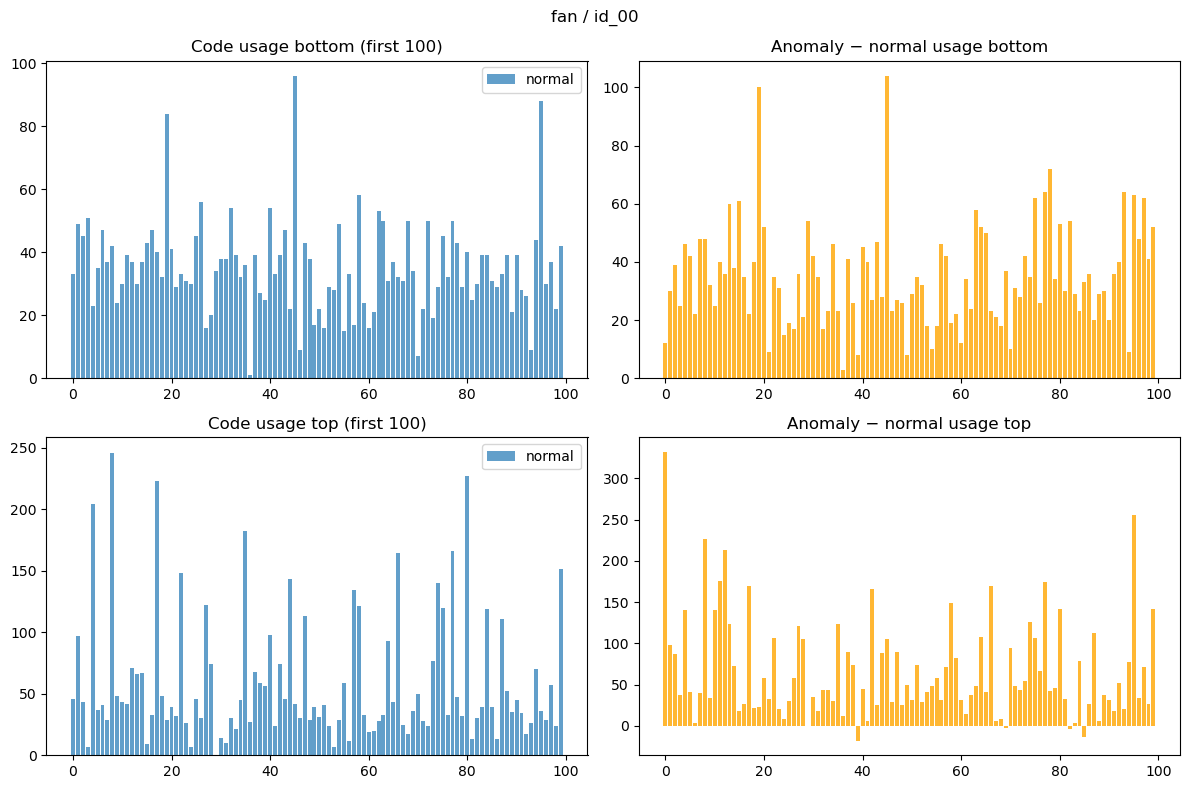

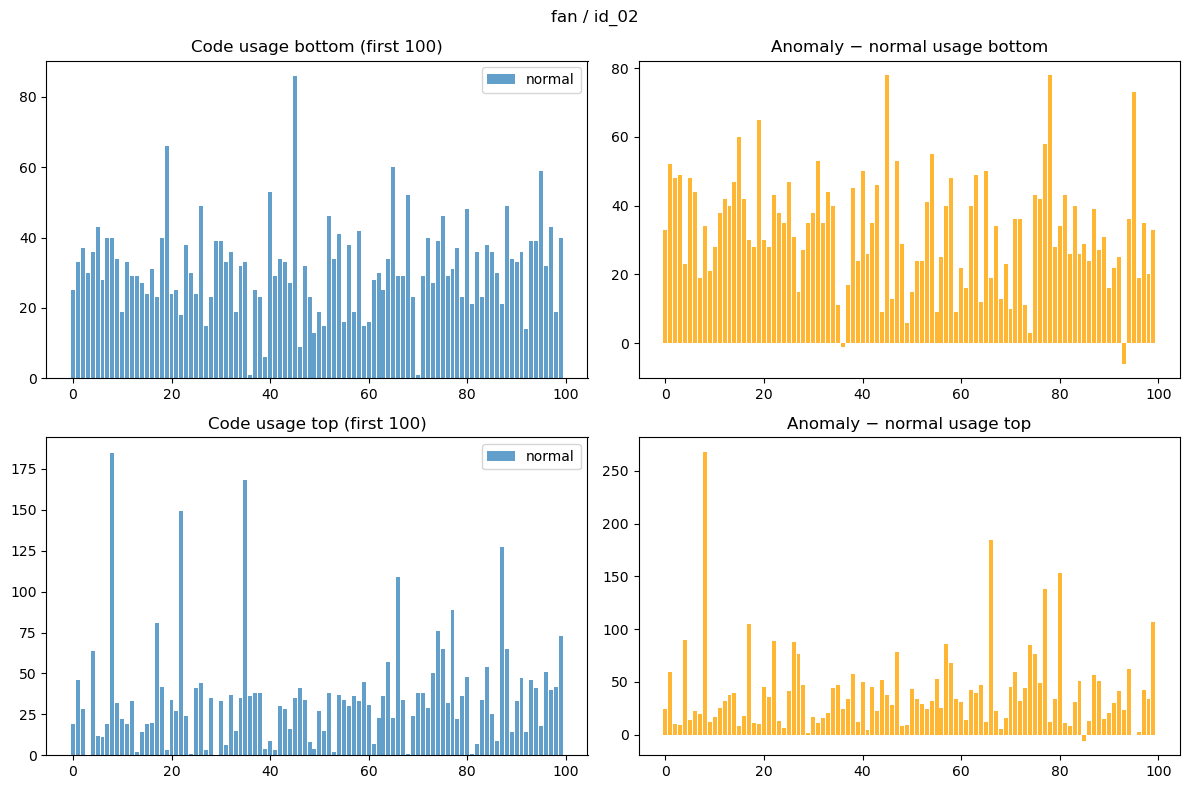

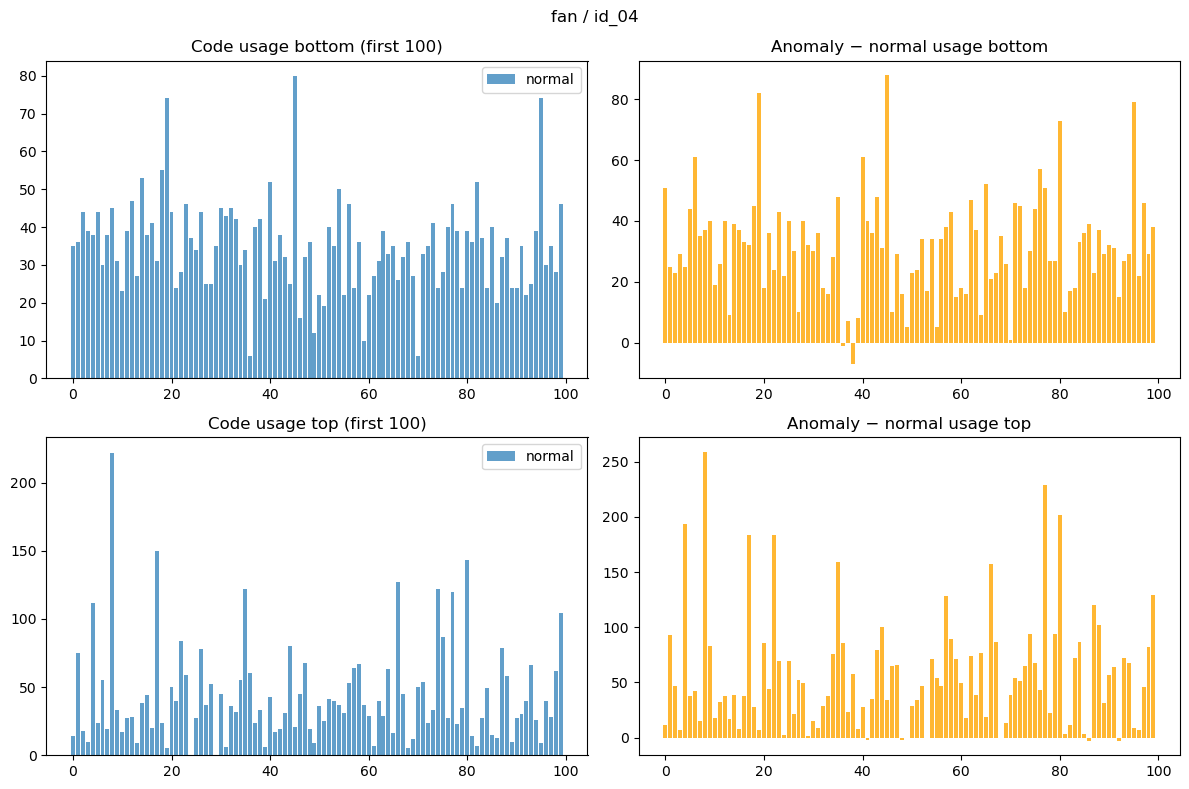

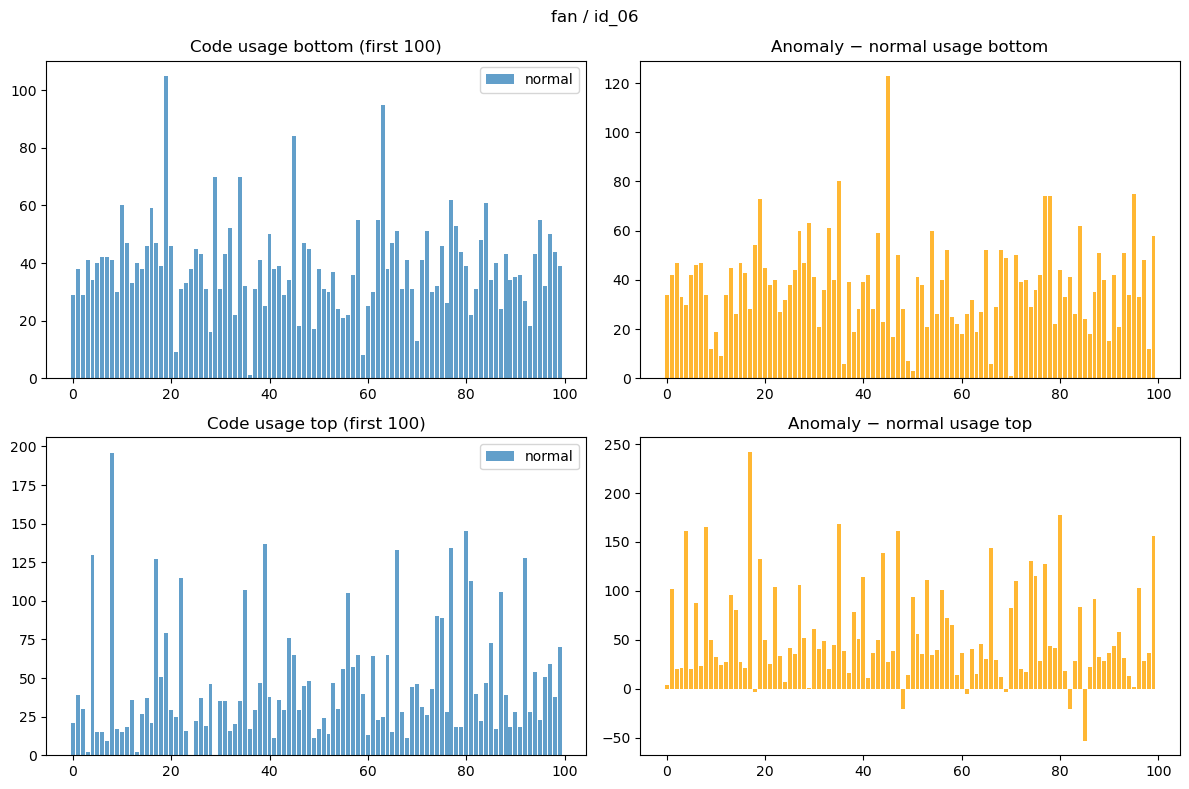

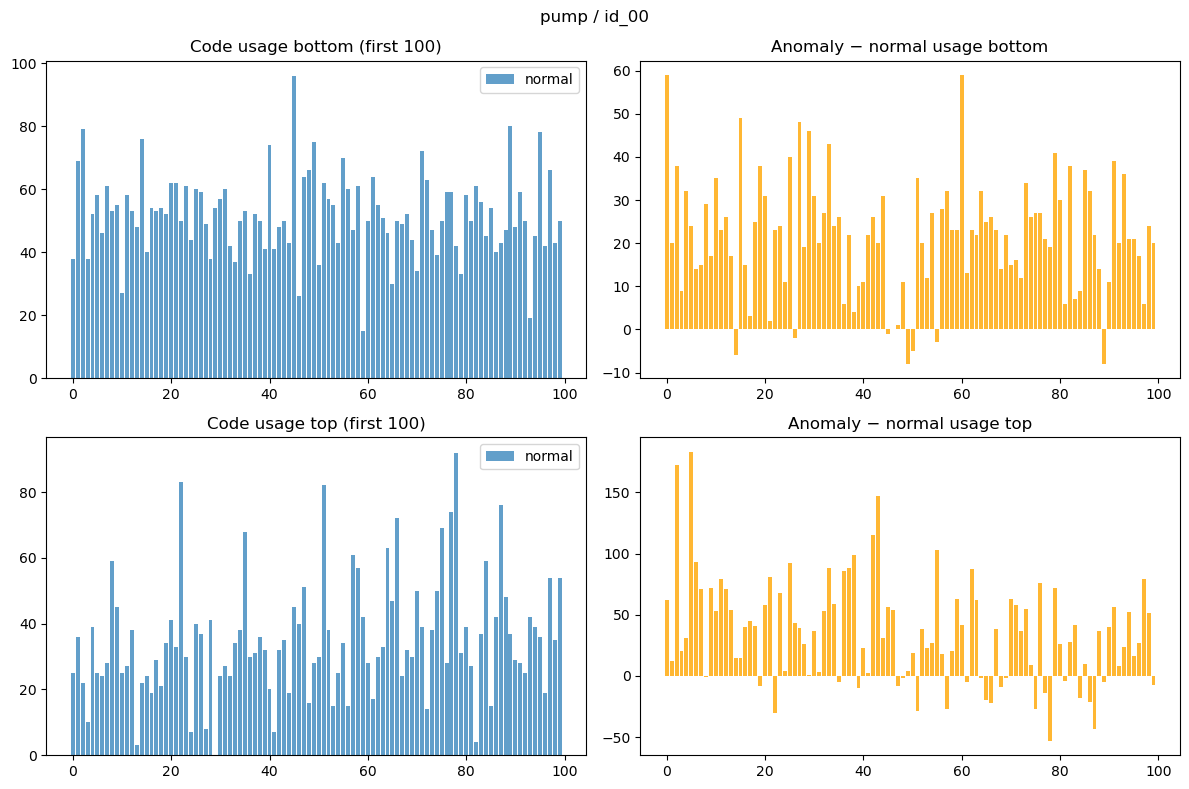

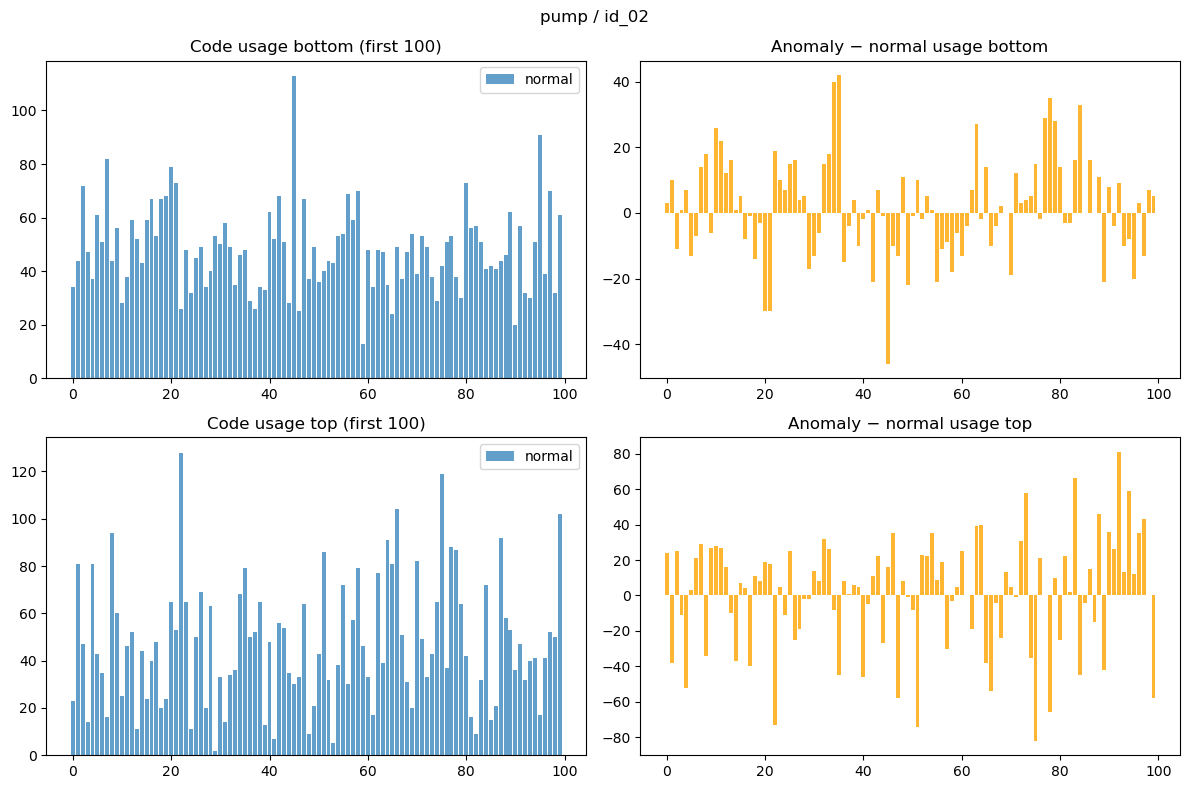

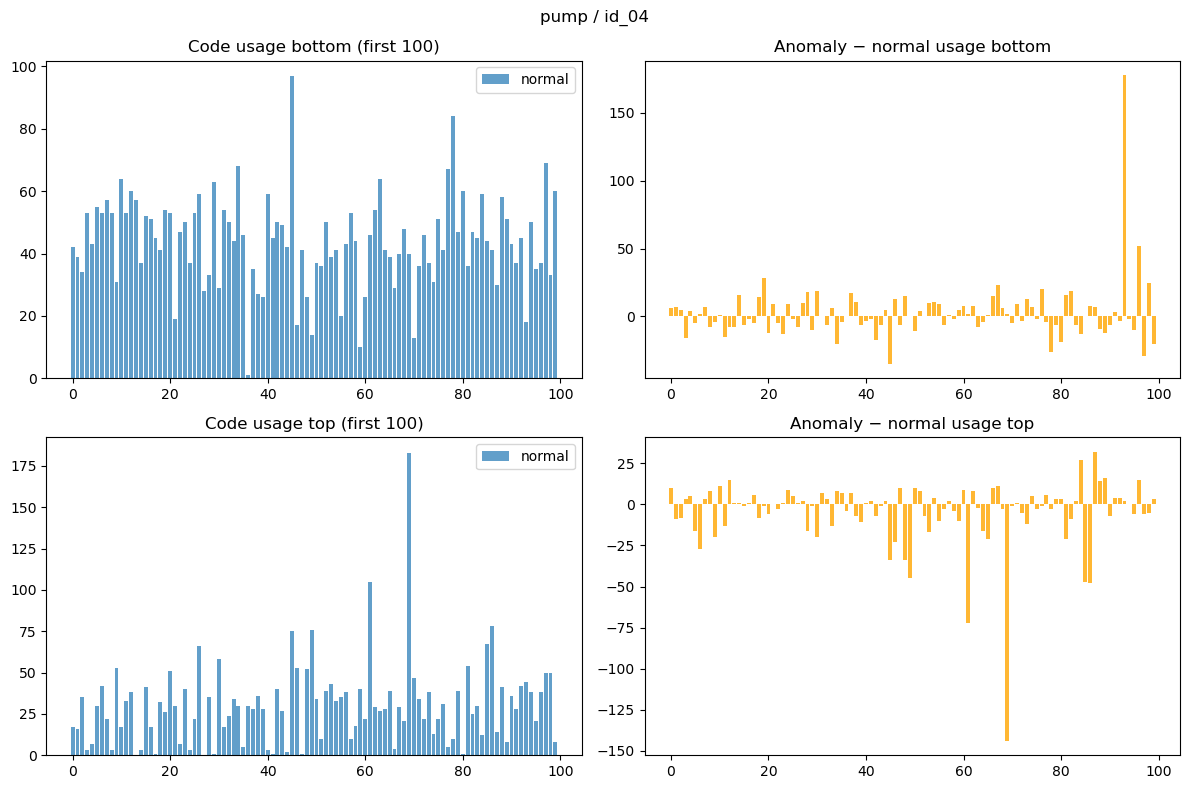

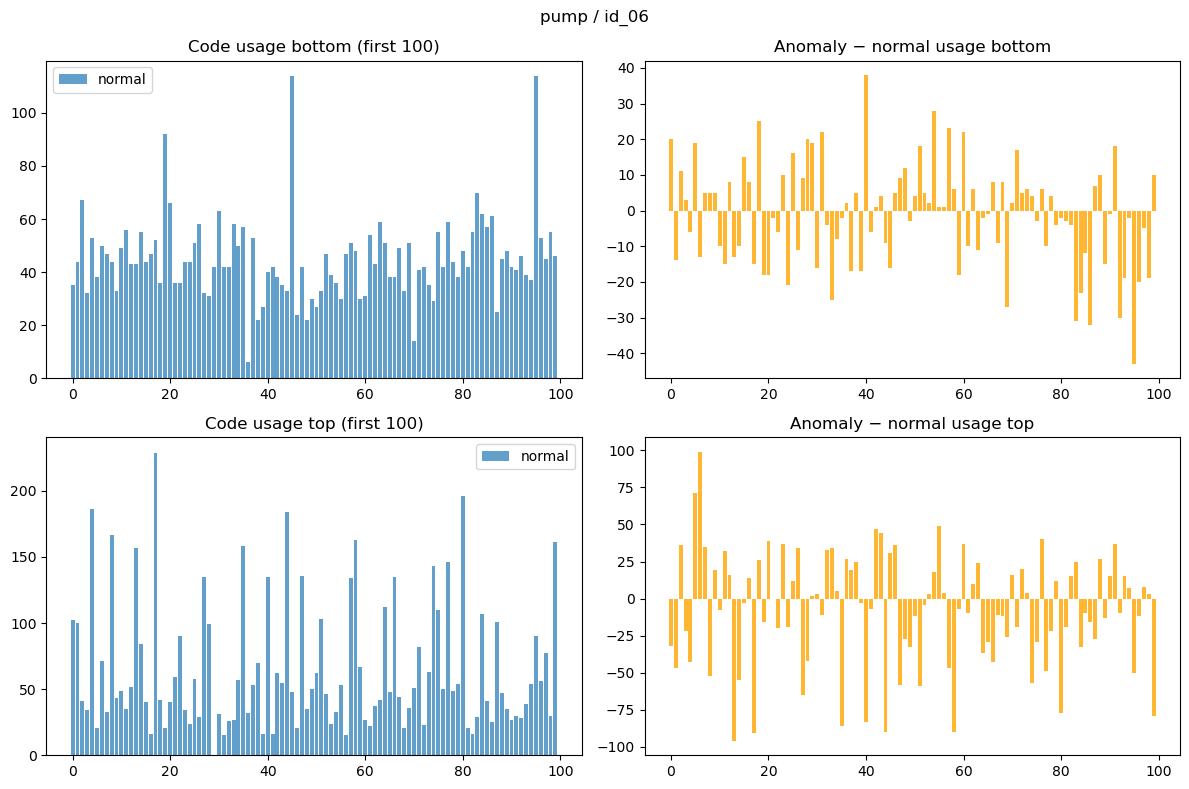

In [8]:
def code_usage_histogram(indices: torch.Tensor, num_codes: int) -> np.ndarray:
    """(B, H, W) -> (num_codes,) counts."""
    if indices is None or indices.numel() == 0:
        return np.zeros(num_codes)
    flat = indices.view(-1).numpy()
    counts = np.bincount(flat, minlength=num_codes)
    return counts[:num_codes]

def plot_code_usage(results, machine_type: str, machine_id: str, num_embeddings_bot: int, num_embeddings_top: int):
    r = results[machine_id]
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for level, name, N in [("bot", "bottom", num_embeddings_bot), ("top", "top", num_embeddings_top)]:
        cn = code_usage_histogram(r[f"indices_{level}_n"], N)
        ca = code_usage_histogram(r[f"indices_{level}_a"], N)
        axes[0 if level == "bot" else 1, 0].bar(np.arange(min(100, N)), cn[:100], alpha=0.7, label="normal")
        axes[0 if level == "bot" else 1, 0].set_title(f"Code usage {name} (first 100)")
        axes[0 if level == "bot" else 1, 0].legend()
        diff = ca.astype(float) - cn.astype(float)
        axes[0 if level == "bot" else 1, 1].bar(np.arange(min(100, N)), diff[:100], color="orange", alpha=0.8)
        axes[0 if level == "bot" else 1, 1].set_title(f"Anomaly − normal usage {name}")
    plt.suptitle(f"{machine_type} / {machine_id}")
    plt.tight_layout()
    plt.show()

NUM_EMBEDDINGS = (1024, 4096)
for mt in MACHINE_TYPES:
    if mt not in results_by_type:
        continue
    for mid in sorted(results_by_type[mt].keys()):
        plot_code_usage(results_by_type[mt], mt, mid, NUM_EMBEDDINGS[1], NUM_EMBEDDINGS[0])

## 4. Spatial map: where do code indices change?

For each machine_id, average over anomalous samples: proportion of samples where index differs from mean normal index at that position (or use mean |index_anom − index_normal|).

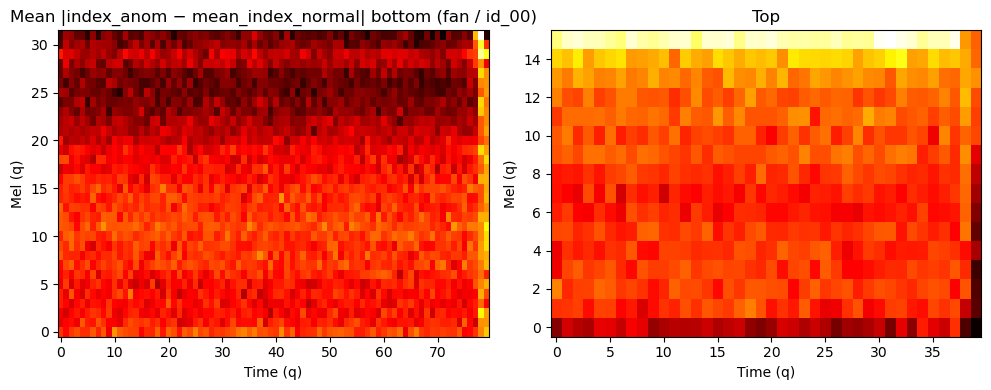

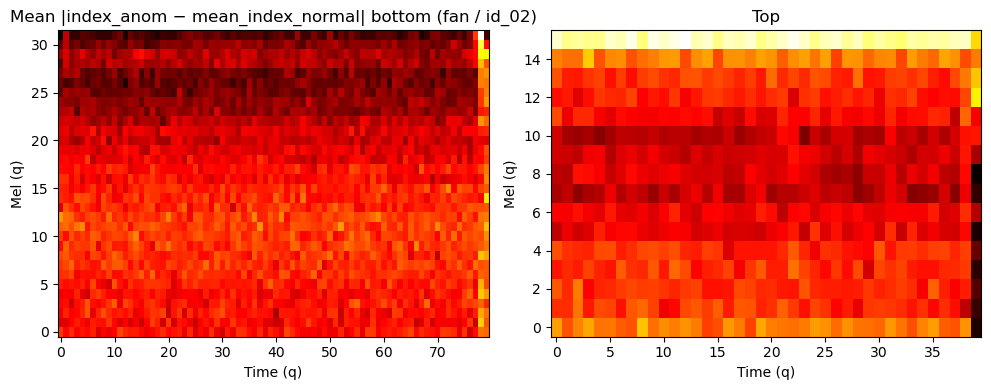

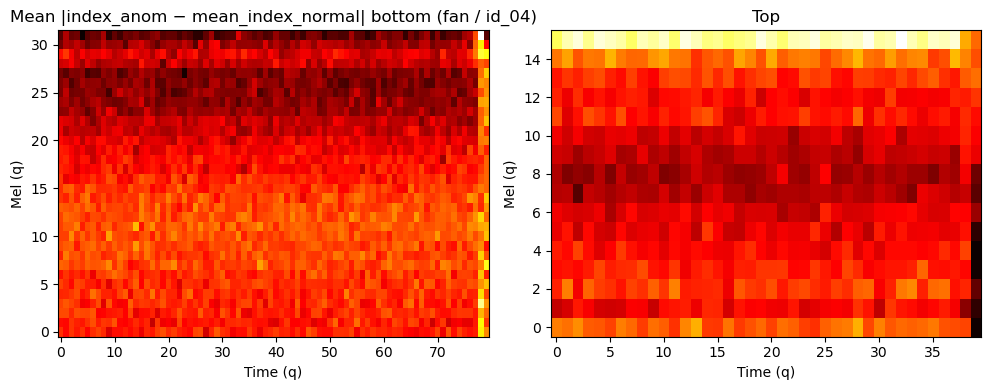

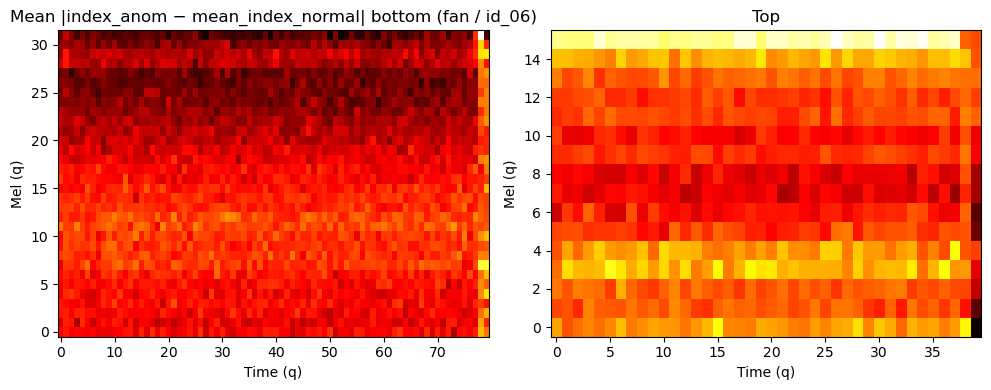

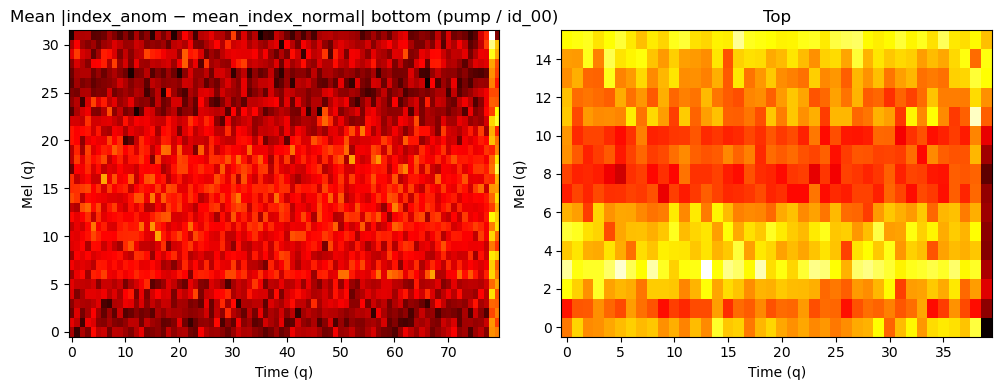

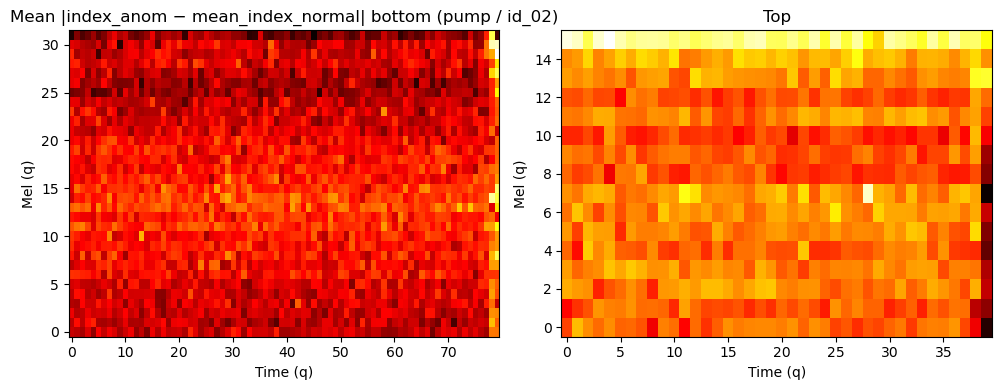

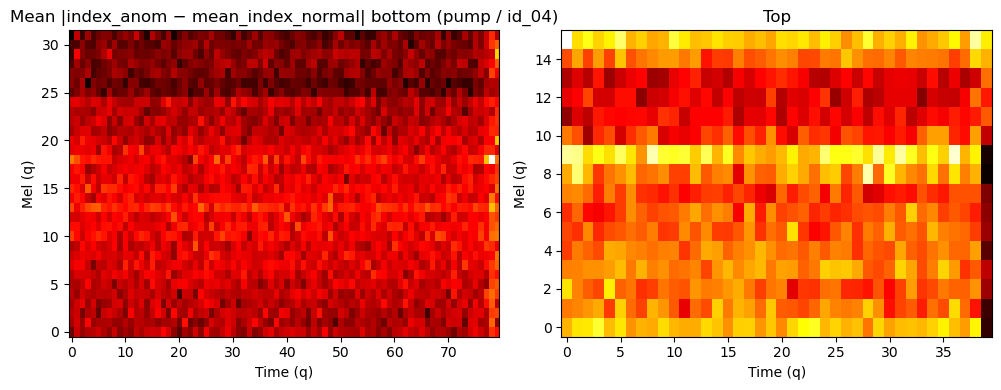

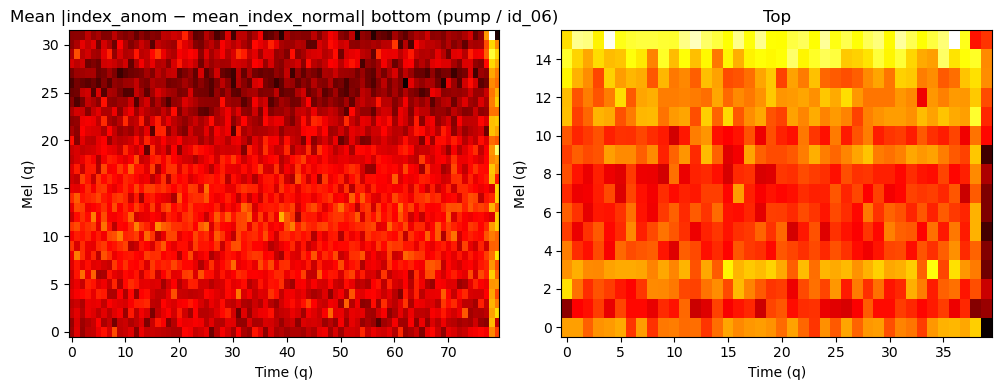

In [9]:
def spatial_change_map(results, machine_id: str) -> tuple[np.ndarray | None, np.ndarray | None]:
    """Return (H, W) map of mean absolute index change (bot, top) or None."""
    r = results[machine_id]
    idx_bot_n = r["indices_bot_n"]
    idx_bot_a = r["indices_bot_a"]
    idx_top_n = r["indices_top_n"]
    idx_top_a = r["indices_top_a"]
    if idx_bot_n is None or idx_bot_a is None or idx_bot_n.shape[0] == 0 or idx_bot_a.shape[0] == 0:
        return None, None
    mean_bot_n = idx_bot_n.float().mean(dim=0)
    mean_top_n = idx_top_n.float().mean(dim=0)
    change_bot = (idx_bot_a.float() - mean_bot_n.unsqueeze(0)).abs().mean(dim=0).numpy()
    change_top = (idx_top_a.float() - mean_top_n.unsqueeze(0)).abs().mean(dim=0).numpy()
    return change_bot, change_top

def plot_spatial_change(results, machine_type: str, machine_id: str):
    change_bot, change_top = spatial_change_map(results, machine_id)
    if change_bot is None:
        return
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(change_bot, aspect="auto", origin="lower", cmap="hot")
    axes[0].set_title(f"Mean |index_anom − mean_index_normal| bottom ({machine_type} / {machine_id})")
    axes[0].set_xlabel("Time (q)")
    axes[0].set_ylabel("Mel (q)")
    axes[1].imshow(change_top, aspect="auto", origin="lower", cmap="hot")
    axes[1].set_title("Top")
    axes[1].set_xlabel("Time (q)")
    axes[1].set_ylabel("Mel (q)")
    plt.tight_layout()
    plt.show()

for mt in MACHINE_TYPES:
    if mt not in results_by_type:
        continue
    for mid in sorted(results_by_type[mt].keys()):
        plot_spatial_change(results_by_type[mt], mt, mid)

## 5. Z vs codebook distance (optional)

For anomalous samples, how far is z from its quantized code? Mean residual per position.

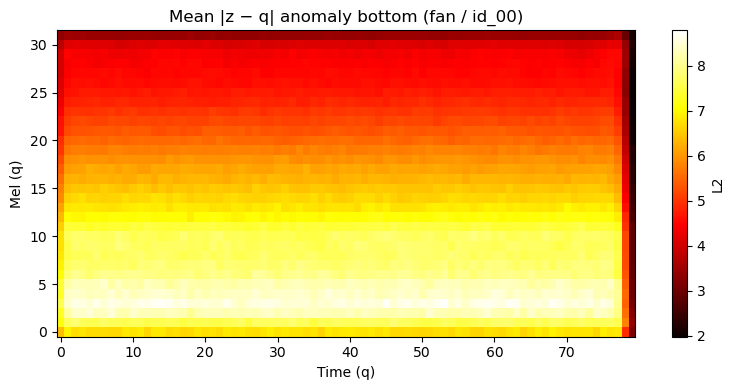

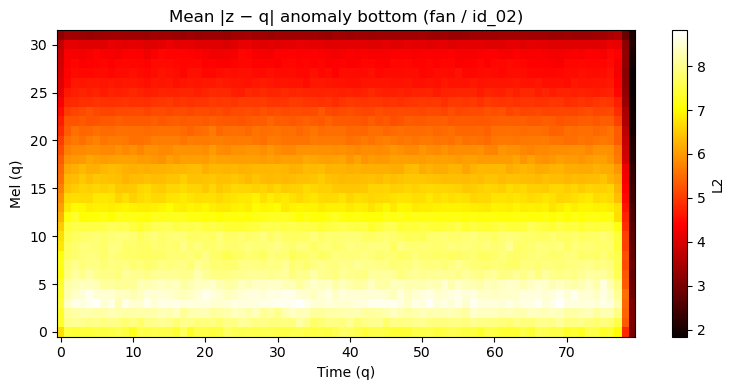

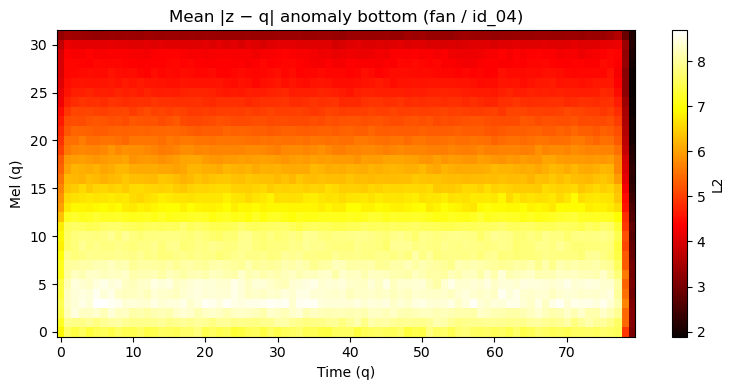

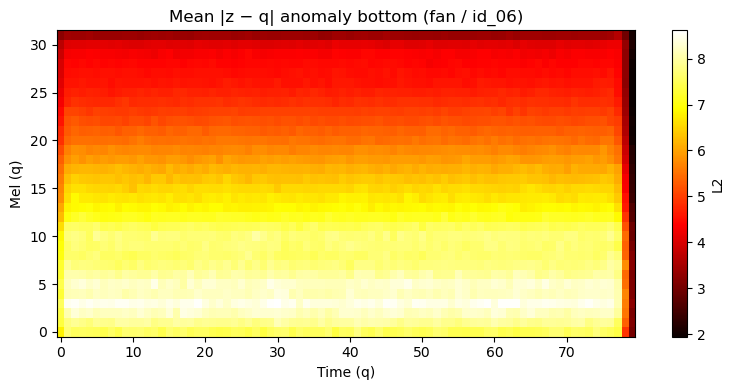

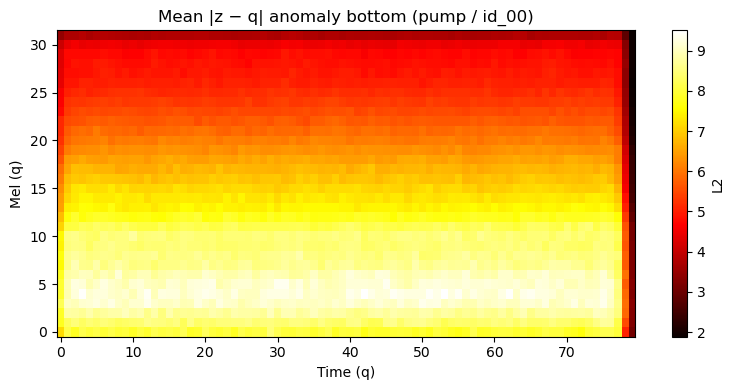

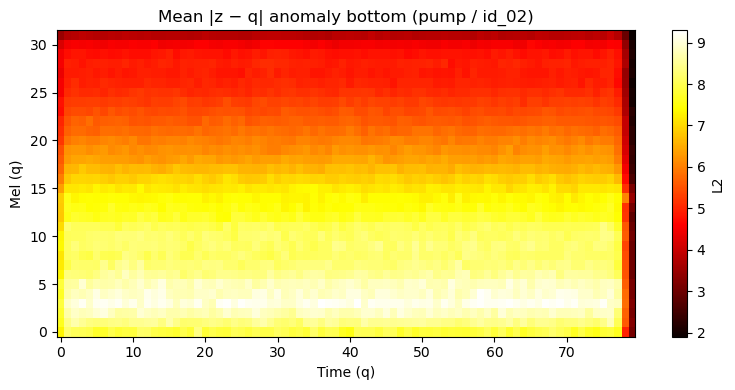

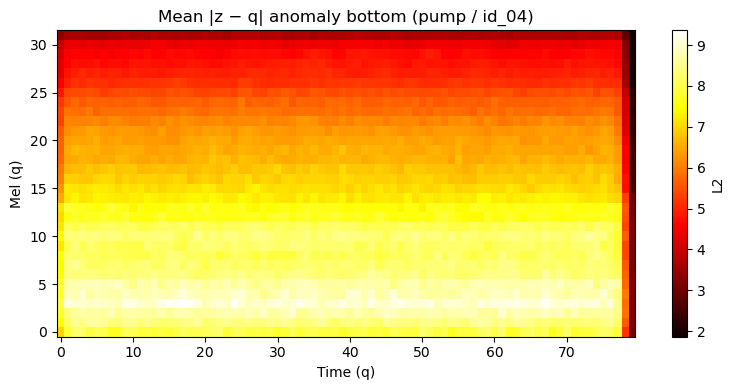

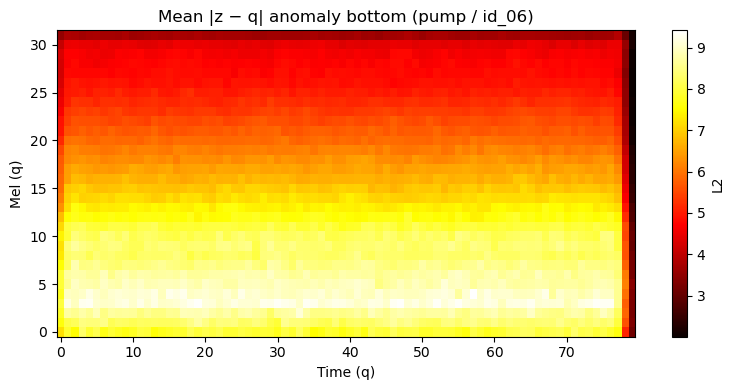

In [10]:
def z_code_distance(z: torch.Tensor, q: torch.Tensor) -> torch.Tensor:
    """(B, C, H, W) -> (B, H, W) L2 distance."""
    return (z - q).pow(2).sum(dim=1).sqrt()

def plot_z_residual(results, machine_type: str, machine_id: str):
    r = results[machine_id]
    z_a = r["z_bot_a"]
    q_a = r["q_bot_a"]
    if z_a is None or q_a is None or z_a.shape[0] == 0:
        return
    dist = z_code_distance(z_a, q_a)
    mean_dist = dist.mean(dim=0).numpy()
    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.imshow(mean_dist, aspect="auto", origin="lower", cmap="hot")
    ax.set_title(f"Mean |z − q| anomaly bottom ({machine_type} / {machine_id})")
    ax.set_xlabel("Time (q)")
    ax.set_ylabel("Mel (q)")
    plt.colorbar(im, ax=ax, label="L2")
    plt.tight_layout()
    plt.show()

for mt in MACHINE_TYPES:
    if mt not in results_by_type:
        continue
    for mid in sorted(results_by_type[mt].keys()):
        plot_z_residual(results_by_type[mt], mt, mid)

## 6. Summary table: preferred q regions, codes over-used in anomalies, strength

Per machine type / ID: peak of spatial change map (preferred q regions for masks); codes with positive anomaly−normal usage (over-used in anomalies); suggested strength range from z-distance.

In [11]:
summary_table = []
for mt in MACHINE_TYPES:
    if mt not in results_by_type:
        continue
    for mid in sorted(results_by_type[mt].keys()):
        r = results_by_type[mt][mid]
        change_bot, change_top = spatial_change_map(results_by_type[mt], mid)
        row = {"machine_type": mt, "machine_id": mid}
        if change_bot is not None:
            peak = np.unravel_index(np.argmax(change_bot), change_bot.shape)
            Hq, Wq = change_bot.shape
            row["q_peak_bot"] = f"mel_q={peak[0]}/{Hq}, time_q={peak[1]}/{Wq}"
        else:
            row["q_peak_bot"] = "N/A"
        cn_bot = code_usage_histogram(r["indices_bot_n"], 4096) if r["indices_bot_n"] is not None else np.zeros(4096)
        ca_bot = code_usage_histogram(r["indices_bot_a"], 4096) if r["indices_bot_a"] is not None else np.zeros(4096)
        diff = ca_bot - cn_bot
        overused = np.where(diff > 0)[0]
        row["n_codes_overused_bot"] = len(overused)
        row["top5_overused_bot"] = np.argsort(-diff)[:5].tolist() if len(overused) else []
        summary_table.append(row)
for row in summary_table:
    print(row)

{'machine_type': 'fan', 'machine_id': 'id_00', 'q_peak_bot': 'mel_q=31/32, time_q=78/80', 'n_codes_overused_bot': 4086, 'top5_overused_bot': [220, 1914, 2692, 534, 3896]}
{'machine_type': 'fan', 'machine_id': 'id_02', 'q_peak_bot': 'mel_q=31/32, time_q=78/80', 'n_codes_overused_bot': 4087, 'top5_overused_bot': [1914, 2692, 220, 3896, 4034]}
{'machine_type': 'fan', 'machine_id': 'id_04', 'q_peak_bot': 'mel_q=31/32, time_q=78/80', 'n_codes_overused_bot': 4082, 'top5_overused_bot': [220, 1914, 2692, 2507, 3422]}
{'machine_type': 'fan', 'machine_id': 'id_06', 'q_peak_bot': 'mel_q=31/32, time_q=78/80', 'n_codes_overused_bot': 4089, 'top5_overused_bot': [220, 1914, 2692, 534, 3896]}
{'machine_type': 'pump', 'machine_id': 'id_00', 'q_peak_bot': 'mel_q=31/32, time_q=78/80', 'n_codes_overused_bot': 3955, 'top5_overused_bot': [3896, 2692, 2515, 3071, 4034]}
{'machine_type': 'pump', 'machine_id': 'id_02', 'q_peak_bot': 'mel_q=29/32, time_q=79/80', 'n_codes_overused_bot': 2693, 'top5_overused_bot'